In [ ]:
import numpy as np
import pandas as pd

from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
# models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
# metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from collections import Counter

# import warnings
# warnings.filterwarnings("ignore")
# %matplotlib inline

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/datasets/ml_homework/news_fake-n-true.csv")
data.head(4)

,Unnamed: 0,title,text,subject,date,label
0,0,ADVISORY: Story on Kushner visiting Iraq withd...,(Reuters) - The story “Trump son-in-law Jared ...,politicsNews,"April 3, 2017",1
1,1,Kasich campaign denies report of Romney endors...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"March 14, 2016",1
2,2,WATCH: Colbert Devises Perfect Advertisement ...,If America is going to end the day Donald Trum...,News,"May 20, 2016",0
3,3,Trump says hopes for Cuban 'freedom' after Cas...,"WEST PALM BEACH, Fla. (Reuters) - U.S. Preside...",politicsNews,"November 26, 2016",1


In [ ]:
data_clean = data.drop(['Unnamed: 0','title','subject','date'], axis=1)
display(data_clean)

,text,label
0,(Reuters) - The story “Trump son-in-law Jared ...,1
1,WASHINGTON (Reuters) - Republican presidential...,1
2,If America is going to end the day Donald Trum...,0
3,"WEST PALM BEACH, Fla. (Reuters) - U.S. Preside...",1
4,"Well, it seems that despite the efforts of not...",0
...,...,...
44893,Donald Trump s economic proposals would be dis...,0
44894,INDIANAPOLIS (Reuters) - President Donald Trum...,1
44895,During a private meeting of the most senior Re...,0
44896,"AMMAN (Reuters) - Sabih al-Masri, Jordan s mos...",1


8.0
6.0


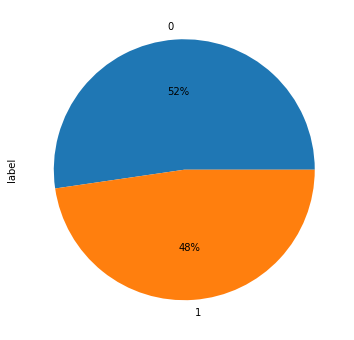

In [ ]:
##########################
# analizing possible dataset imbalance
##########################

plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size
# there's evident imbalance in categories
data_clean.label.value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

In [ ]:
# analize - are there any NaN values. 
data_clean.isna().sum() 

text     0
label    0
dtype: int64

In [ ]:
##########################
# preparing lemmatized text features
##########################

# lemmatizing
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    '''lemmatizes text for the given pos tags - NN,VB,JJ'''

    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(text)):

        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

def preprocess_text(text):
    '''Removes html tags, '\n', double spaces and 'nbsp;', etc.'''

    TAG_RE = re.compile(r'<[^>]+>')
    text = TAG_RE.sub('', text)
    text = re.sub(' +', ' ', text)
    text = text.replace("&nbsp;", " ")
    text = text.replace("\n", " ")
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    # Converting to Lowercase
    text = text.lower()

    return text

data_clean['text'] = data_clean['text'].apply(lambda text: preprocess_text(text))
data_clean['text'] = data_clean['text'].apply(lambda text: ' '.join(lemmatize(text)))

print(data_clean['text'][100:200])

100    washington reuters president donald trump try ...
101    they shoot him in the head with 45 they find o...
102    two florida republican lawmaker vote against 1...
103    jill stein green party candidate for president...
104    just one day after paul ryan fail to garner su...
                             ...                        
195    when you think of civil right activist it not ...
196    beijing reuters japan talk only about sanction...
197    of course there no official word from the whit...
198    washington reuters obama administration offici...
199    lyin donald trump tweet this morning that form...
Name: text, Length: 100, dtype: object


In [ ]:
data_clean.to_csv('/content/drive/MyDrive/datasets/ml_homework/fake_preprocessed.csv')

In [ ]:
##########################
# preparing features/labels datasets
##########################

features = data_clean.iloc[:, 0].values
labels = data_clean.iloc[:, 1].values

print(features)
print(labels)

['reuters the story trump son in law jar kushner visit iraq official say the accompany alert and subsequent update be wrong and be withdraw substitute story be available here'
 'washington reuters republican presidential candidate john kasich campaign on monday deny report that mitt romney the party presidential candidate in 2012 would endorse the ohio governor on monday wall street journal reporter say kasich answer in the affirmative to question about romney endorsement kasich spokesman chris schrimpf say this be not true kasich be respond and acknowledge different question romney endorsement would have provide kasich with boost on the eve of ohio primary in which he and front runner donald trump be run close race for first place'
 'if america be go to end the day donald trump take the nomination at the gop convention stephen colbert be not go to miss out on mock it during the late show on thursday night colbert relentlessly mock the presumptive republican presidential nominee for ru

In [ ]:
##################
# vectorizing text with Tf-idf
##################

# tf_idf_params
max_features = 7500
min_df = 0
decode_error = 'ignore'
max_df = 0.8
stop_words = text.ENGLISH_STOP_WORDS
analyzer = 'word'

vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, decode_error=decode_error, max_df=max_df, stop_words=stop_words)
# vectorizer = CountVectorizer(stop_words=en_stop_words, max_features=10000)
processed_features = vectorizer.fit_transform(features).toarray()

print(processed_features)

result = np.where(processed_features > 0)
print(list(result))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[array([    0,     0,     0, ..., 44897, 44897, 44897]), array([ 256,  408,  682, ..., 6730, 6808, 7189])]


In [ ]:
##########################
# Train-test split
##########################
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.33, random_state=42)

In [ ]:
##########################
# pipelines for training different models
##########################

sgd = Pipeline([
        # ("tfidf_vectorizer", tfidf),
        ("sgd", SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))
    ])

svc = Pipeline([
        ("svc", SVC(random_state=4, kernel='rbf'))
    ])

log_reg = Pipeline([ 
    ('log_reg', LogisticRegression(penalty="elasticnet",l1_ratio=0.5,solver="saga", random_state=4, n_jobs=-1))
    ])

naive_bayes = Pipeline([          
        ('naive_bayes', MultinomialNB()),          
    ])

decision_trees = Pipeline([
    ('decision_trees', DecisionTreeClassifier())
    ])

extra_trees = Pipeline([
    ('extra_trees', ExtraTreesClassifier(random_state=4, n_jobs=-1, max_features="auto", warm_start=True))
    ])

random_forest = Pipeline([
        ('random_forest', RandomForestClassifier(n_estimators=200, random_state=4, n_jobs=-1, max_features="auto", warm_start=True)),
    ])

grad_boost = Pipeline([          
        ('grad_boost', GradientBoostingClassifier(random_state=4, subsample=0.8, max_features="auto", warm_start=True)),          
    ])

all_models = [
    ("sgd", sgd),
    ("svc", svc),
    ("log_reg", log_reg),
    # ('naive_bayes', naive_bayes),
    # ("decision_trees", decision_trees),
    # ("extra_trees", extra_trees),
    # ("random_forest", random_forest),
    # ("grad_boost", grad_boost),
    ]

##########################
# scoring models
##########################
unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print(scores)


[('svc', 0.9852398855362718), ('log_reg', 0.979654969236569), ('sgd', 0.9674546023670053)]


In [ ]:
##########################
# Train the best model
##########################
model = svc
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred[:10])
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[1 0 1 1 0 0 1 0 0 0]
0.9909563339407438
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7796
           1       0.99      0.99      0.99      7021

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817

[[7716   80]
 [  54 6967]]
